# Optimizer Example
Jena Climate ANN example showing the effects of dropout rates on the Adam optimizer.
This is a regression model, using 3-hour data

Gabriella Ferro & Richard Henry, 18-Jul-2024

In [1]:
#Import Libararies
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

Test Libraries

In [2]:
# Check python version
from platform import python_version
print(python_version())
#3.12.3

3.12.3


In [3]:
# Check tensorflow version
tf.__version__
#2.16.1

'2.17.0'

In [4]:
# Check keras version
tf.keras.__version__
#3.4.1

'3.4.1'

# Jena ANN

In [5]:
# Load Data (Already cleaned and decimated)
# Jupyter Notebook Edition
df3=pd.read_csv('dataset/Jena_climate/cleanJena3.csv')

Adjustment for Google Colab

In [6]:
#from google.colab import drive
#drive.mount('/content/drive')

In [7]:
#!ls "/content/drive/MyDrive/DeepLearingGroup2/code/dataset/Jena_climate"

In [8]:
#df3=pd.read_csv('/content/drive/MyDrive/DeepLearingGroup2/code/dataset/Jena_climate/cleanJena.csv')

End Adjustment for Google Colab

In [9]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23363 entries, 0 to 23362
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   p (mbar)       23363 non-null  float64
 1   VPact (mbar)   23363 non-null  float64
 2   Tdew (degC)    23363 non-null  float64
 3   T (degC)       23363 non-null  float64
 4   max. wv (m/s)  23363 non-null  float64
 5   NSwind         23363 non-null  float64
 6   EWwind         23363 non-null  float64
 7   year           23363 non-null  int64  
 8   month          23363 non-null  int64  
 9   day            23363 non-null  int64  
 10  hour           23363 non-null  int64  
dtypes: float64(7), int64(4)
memory usage: 2.0 MB


In [10]:
df3.describe()

,p (mbar),VPact (mbar),Tdew (degC),T (degC),max. wv (m/s),NSwind,EWwind,year,month,day,hour
count,23363.000000,23363.000000,23363.000000,23363.000000,23363.000000,23363.000000,23363.000000,23363.000000,23363.000000,23363.000000,23363.000000
mean,989.216246,9.533017,4.954671,9.456338,3.533382,-0.631798,-0.415655,2012.497068,6.517399,15.713222,10.500449
std,8.353071,4.184973,6.730860,8.428081,2.339862,1.983549,1.553730,2.289905,3.448433,8.799298,6.873702
min,942.720000,0.810000,-24.800000,-22.760000,0.000000,-10.783959,-7.148867,2009.000000,1.000000,1.000000,0.000000
25%,984.200000,6.220000,0.240000,3.340000,1.760000,-1.480647,-1.372670,2010.000000,4.000000,8.000000,6.000000
50%,989.590000,8.860000,5.210000,9.440000,2.980000,-0.637933,-0.296919,2012.000000,7.000000,16.000000,12.000000
75%,994.730000,12.360000,10.080000,15.480000,4.730000,0.306138,0.432981,2014.000000,10.000000,23.000000,15.000000
max,1015.170000,28.040000,22.940000,36.460000,18.780000,7.709359,6.966350,2017.000000,12.000000,31.000000,21.000000


In [11]:
# Model / data parameters
blk_len=16*8      #Look back at two weeks of data
stp_len=8         #look forward 24 hours
row_len=len(df3)   #total records (last target location)
col_len=11         #total variables
bat_len=64*8      #batch size of 2 months
epo_len=32         #32 epochs
val_fra=0.2        #use 20% of data for validation
pas_len=blk_len+stp_len  #first target location
cut_len=row_len-pas_len  #last start of predictor location
drop_01=0.2        #First dropout layer
drop_02=0.2        #Second dropout layer

In [12]:
%%time
# Reformat
y_train=df3['T (degC)'].iloc[pas_len:].to_numpy()  #pull out all the targets
#start building predictor deck
xAll=df3.to_numpy()
xTrain=np.zeros([cut_len,blk_len,col_len])
for i in range(cut_len):
    for j in range(blk_len):
            xTrain[i][j][:]=xAll[i+j][:]

CPU times: total: 2.61 s
Wall time: 3.83 s


In [13]:
#Normalize Input Data
fixMe=tf.keras.layers.Normalization()
fixMe.adapt(xTrain)

In [14]:
# Build & train model function
def model_build(drop1st,drop2nd):
    #Build it exactly the same every time
    tf.random.set_seed(19)
    model = tf.keras.Sequential(
        [
            tf.keras.Input(shape=(blk_len,col_len)),
            fixMe,
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(64,
                                  activation='relu'),
            tf.keras.layers.Dropout(drop1st),
            tf.keras.layers.Dense(32,
                                  activation='relu'),
            tf.keras.layers.Dropout(drop2nd),
            tf.keras.layers.Dense(1,
                                  activation='linear')
        ]
    )
    model.compile(loss='mean_squared_error',
                  optimizer='adam')
    myHis=model.fit(xTrain,
                    y_train,
                    batch_size=bat_len,
                    epochs=epo_len,
                    validation_split=val_fra,
                   verbose=0)
    #myPre=model.predict(xTrain)
    myEva=model.evaluate(xTrain,
                         y_train,
                        verbose=0)
    return myEva

### First Model, Adam

In [23]:
%%time
q=np.arange(0.0,13.0/16.0,1.0/16.0)
u=len(q)
r=np.arange(u)
s=np.zeros((u,u))
for i in r:
    drop_01=q[i]
    for j in r:
        drop_02=q[j]
        e0=model_build(drop_01,drop_02)
        print(drop_01,drop_02,e0)
        s[i,j]=e0

0.0 0.0 5.344531536102295
0.0 0.0625 5.4419636726379395
0.0 0.125 5.519043922424316
0.0 0.1875 5.450360298156738
0.0 0.25 5.429183483123779
0.0 0.3125 6.11740255355835
0.0 0.375 5.936070442199707
0.0 0.4375 6.275309085845947
0.0 0.5 7.7605695724487305
0.0 0.5625 7.317038059234619
0.0 0.625 7.105822563171387
0.0 0.6875 8.417366981506348
0.0 0.75 9.107661247253418
0.0625 0.0 5.214359760284424
0.0625 0.0625 5.243708610534668
0.0625 0.125 5.785333156585693
0.0625 0.1875 6.179978370666504
0.0625 0.25 5.967288017272949
0.0625 0.3125 6.524505615234375
0.0625 0.375 6.520564556121826
0.0625 0.4375 6.74485445022583
0.0625 0.5 8.027664184570312
0.0625 0.5625 7.137206077575684
0.0625 0.625 8.223516464233398
0.0625 0.6875 9.74994945526123
0.0625 0.75 10.66358757019043
0.125 0.0 5.5176167488098145
0.125 0.0625 5.664641380310059
0.125 0.125 5.6623077392578125
0.125 0.1875 6.454704284667969
0.125 0.25 5.810476303100586
0.125 0.3125 6.500608921051025
0.125 0.375 7.3474626541137695
0.125 0.4375 6.334085

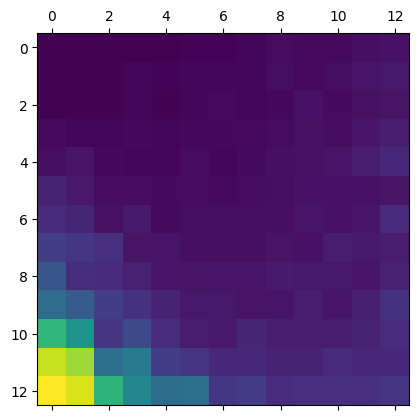

In [24]:
plt.matshow(s)
plt.show()

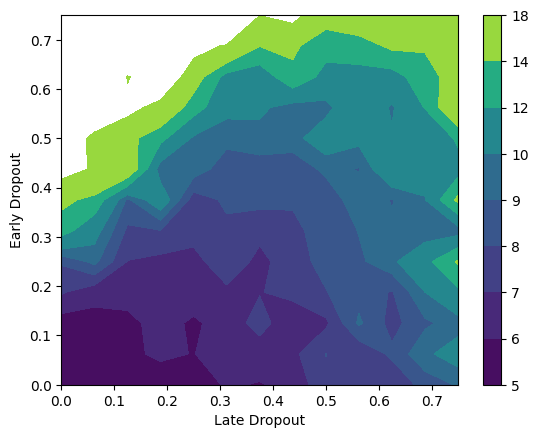

In [25]:
levels=[5,6,7,8,9,10,12,14,18]
fig, ax=plt.subplots()
CS=ax.contourf(q,q,s,levels)
#ax.clabel(CS,inline=True)
ax.set_xlabel("Late Dropout")
ax.set_ylabel("Early Dropout")
cbar=fig.colorbar(CS)

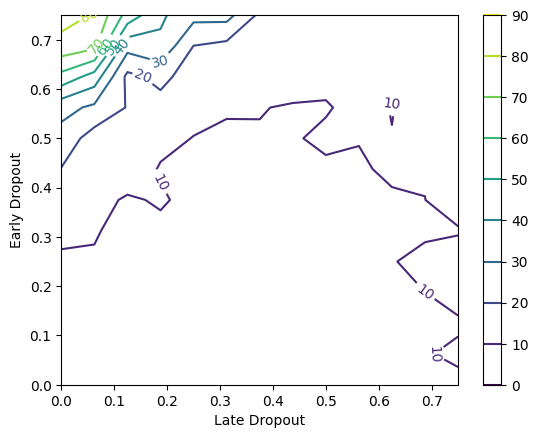

In [27]:
levels=[5,6,7,8,9,10,12,14,18]
fig, ax=plt.subplots()
CS=ax.contour(q,q,s)
ax.clabel(CS,inline=True)
ax.set_xlabel("Late Dropout")
ax.set_ylabel("Early Dropout")
cbar=fig.colorbar(CS)